# Лабораторная работа №5

### Вариант №4

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np


# Параметры задачи
a = 1.0  # Коэффициент теплопроводности
T = 5    # Время моделирования
l0 = 0   # Левая граница области
l1 = math.pi  # Правая граница области

# Функции для задания граничных и начальных условий
def phi_0(t, a=a):
    return math.exp(-a * t)  # Значение производной на левой границе x=0

def phi_l(t, a=a):
    return -math.exp(-a * t)  # Значение производной на правой границе x=π

def u_0(x):
    return math.sin(x)  # Начальное распределение температуры

# Аналитическое решение задачи
def u(x, t, a=a):
    return math.exp(-a * t) * math.sin(x)

# Генерация массива точек для пространственной или временной сетки
def nums_list(start, end, step=1, eps=1e-10):
    res = []
    current = start
    while abs(current - eps) <= end:
        res.append(current)
        current += step
    return res

## Конечно-разностная схема

In [3]:
# Абстрактный класс для реализации численных схем
class abstract_scheme:
    def __init__(self, a=a, f0=phi_0, fl=phi_l, u0=u_0, teta=0.5, l0=l0, l1=l1, T=T, approx_scheme=None):
        # Граничные условия
        self.f0 = f0  # Левая граница
        self.fl = fl  # Правая граница
        
        # Начальное условие
        self.u0 = u0
        
        # Параметры задачи
        self.T = T        # Время моделирования
        self.l0 = l0      # Левая граница области
        self.l1 = l1      # Правая граница области
        self.a = a        # Коэффициент теплопроводности
        self.teta = teta  # Параметр схемы (0 - явная, 1 - неявная, 0.5 - Кранк-Николсон)
        
        # Аппроксимация граничных условий
        self.approx = None
        if approx_scheme is not None:
            self.approx = approx_scheme(self.f0, self.fl)
    
    # Метод, который будет реализован в подклассах
    def next_layer(self, t, x, cur_layer):
        pass
    
    # Основной метод вызова схемы
    def __call__(self, N=20, K=1100, tau=None, h=None, sigma=None):  
        # Устанавливаем шаги сетки
        if N is not None and K is not None:
            if tau is not None:  # Если шаг по времени задан
                self.tau = tau
            else:  # Иначе вычисляем его
                self.tau = self.T / (K-1)
            if h is not None:  # Если шаг по пространству задан
                self.h = h
            else:  # Иначе вычисляем его
                self.h = (self.l1 - self.l0) / (N-1)
        
        # Если задан параметр sigma, пересчитываем шаги
        if sigma is not None:
            self.sigma = sigma
            if K is not None and N is None:  # Если задано K, но не N
                self.tau = self.T / (K-1)
                self.h = (self.tau * self.a**2 / self.sigma) ** 0.5
            elif N is not None and K is None:  # Если задано N, но не K
                self.h = (self.l1 - self.l0) / (N-1)
                self.tau = self.sigma * self.h**2 / (self.a**2)
        else:
            # Если sigma не задано, вычисляем его
            self.sigma = self.a**2 * self.tau / (self.h**2)
        
        # Решение: список слоёв
        ans = []
        x = nums_list(self.l0, self.l1, self.h)  # Пространственная сетка
        
        # Первый слой (начальное условие)
        cur_layer = list(map(self.u0, x))  # Применяем начальное условие
        ans.append(list(cur_layer))
        
        # Вычисление всех слоёв
        for t in nums_list(self.tau, self.T, self.tau):
            ans.append(self.next_layer(t, x, cur_layer))  # Новый слой
            cur_layer = ans[-1]
        
        return ans
    
# Метод для аналитического решения задачи
class exact_solution:
    def __init__(self, a=a, l0=l0, l1=l1, T=T, exact_f=u):
        # Параметры задачи
        self.a = a          # Коэффициент теплопроводности
        self.l0 = l0        # Левая граница
        self.l1 = l1        # Правая граница
        self.T = T          # Время моделирования
        self.exact_f = exact_f  # Аналитическое решение
    
    # Метод для вычисления аналитического решения
    def __call__(self, N=20, K=1100, h=None, tau=None, sigma=None):    
        # Устанавливаем параметры сетки
        if N is not None and K is not None:    
            if h is None:  # Шаг по пространству
                h = (self.l1 - self.l0) / (N-1)
            if tau is None:  # Шаг по времени
                tau = self.T / (K-1)
        elif sigma is not None:
            # Вычисление шагов, если задано sigma
            if K is not None and N is None:
                tau = self.T / (K-1)
                h = (tau * self.a**2 / sigma) ** 0.5
            elif N is not None and K is None:
                h = (self.l1 - self.l0) / (N-1)
                tau = sigma * h**2 / (self.a**2)    
        
        ans = []  # Список для хранения слоёв (результатов)
        
        # Вычисление значений на каждом временном слое
        for t in nums_list(0, self.T, tau):
            cur_layer = []
            for x in nums_list(self.l0, self.l1, h):
                cur_layer.append(self.exact_f(x, t, self.a))  # Аналитическое решение
            ans.append(cur_layer)
        
        return ans

## Явная конечно-разностная схема

In [4]:
# Реализация явной конечно-разностной схемы
class explicit_scheme(abstract_scheme):        
    def next_layer(self, t, x, previous_line):
        # Проверка условия устойчивости явной схемы
        # Условие: sigma <= 0.5, где sigma = a^2 * tau / h^2.
        # Если sigma > 0.5, схема становится нестабильной.
        if (self.sigma > 0.5):
            raise Exception("sigma > 0.5")  # Выбрасываем исключение, чтобы предотвратить выполнение.

        # Инициализация нового слоя. Создаётся массив того же размера, что и предыдущий слой.
        # Значения будут рассчитываться для каждого узла сетки.
        line = [None] * len(previous_line)

        # Вычисление значений для внутренних точек (от 1 до len(x) - 2).
        # Формула:
        # u_i^{n+1} = sigma * u_{i-1}^n + (1 - 2 * sigma) * u_i^n + sigma * u_{i+1}^n
        # Здесь:
        # - sigma = a^2 * tau / h^2 — параметр, зависящий от коэффициента теплопроводности и шага сетки.
        # - u_i^{n+1} — значение в узле i на новом временном слое.
        # - u_{i-1}^n, u_i^n, u_{i+1}^n — значения в соседних узлах на предыдущем временном слое.
        for i in range(1, len(x) - 1):
            line[i] = self.sigma * previous_line[i-1] + \
                      (1 - 2 * self.sigma) * previous_line[i] + \
                      self.sigma * previous_line[i+1]

        # Вычисление значения на левом крае (x = 0) с использованием аппроксимации граничного условия.
        # Метод explict_0() реализован в классах аппроксимации (например, approx_two_one).
        # Аргументы:
        # - t: текущее время.
        # - self.h: шаг по пространству.
        # - self.sigma: параметр схемы.
        # - previous_line: значения на предыдущем временном слое.
        # - line: текущий слой (частично заполненный).
        # - t - self.tau: время на предыдущем временном слое.
        line[0] = self.approx.explict_0(t, self.h, self.sigma, previous_line, line, t - self.tau)

        # Вычисление значения на правом крае (x = pi) аналогично.
        line[-1] = self.approx.explict_l(t, self.h, self.sigma, previous_line, line, t - self.tau)

        # Возвращаем рассчитанный слой.
        return line

## Неявная конечно-разностная схема. Схема Кранка-Николсона

In [5]:
# Реализация метода прогонки для решения систем уравнений
def tridiagonal_matrix_method(A, B):
    P = [-item[2] for item in A]
    Q = [item for item in B]
    
    # Прямая прогонка
    P[0] /= A[0][1]
    Q[0] /= A[0][1]
    for i in range(1, len(B)):
        z = (A[i][1] + A[i][0] * P[i - 1])
        P[i] /= z
        Q[i] -= A[i][0] * Q[i - 1]
        Q[i] /= z
    
    # Обратная прогонка
    x = [item for item in Q]
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]
    
    return x

# Реализация схемы Кранка-Николсона (включает неявную схему при teta=1)
class krank_nikolson(abstract_scheme):
    def next_layer(self, t, x, previous_line):
        # Определяем коэффициенты для трёхдиагональной матрицы.
        # Эти коэффициенты соответствуют неявной части уравнения.
        a = self.sigma * self.teta  # Коэффициент при u[i-1]^(n+1)
        b = -1 - 2 * self.sigma * self.teta  # Коэффициент при u[i]^(n+1)
        c = self.sigma * self.teta  # Коэффициент при u[i+1]^(n+1)

        # Создаём матрицу коэффициентов A и правую часть B для внутренних точек.
        # В A хранятся тройки (a, b, c), а в B — правая часть системы.
        A = [(a, b, c) for _ in range(1, len(x) - 1)]  # Матрица трёхдиагональной системы.
        B = [
            -(
                previous_line[i] +
                (1 - self.teta) * self.sigma *
                (previous_line[i - 1] - 2 * previous_line[i] + previous_line[i + 1])
            )
            for i in range(1, len(x) - 1)
        ]  # Правая часть, учитывающая явную составляющую.

        # Добавляем граничные условия в систему уравнений.
        # Для левой границы:
        koeffs = self.approx.nikolson_0(t, self.h, self.sigma, previous_line, self.teta, t - self.tau)
        A.insert(0, koeffs[:-1])  # Добавляем коэффициенты для первой строки (левая граница).
        B.insert(0, koeffs[-1])  # Добавляем значение правой части для левой границы.

        # Для правой границы:
        koeffs = self.approx.nikolson_l(t, self.h, self.sigma, previous_line, self.teta, t - self.tau)
        A.append(koeffs[:-1])  # Добавляем коэффициенты для последней строки (правая граница).
        B.append(koeffs[-1])  # Добавляем значение правой части для правой границы.

        # Решаем систему уравнений методом прогонки (tridiagonal_matrix_method).
        # Возвращаем новый временной слой.
        return tridiagonal_matrix_method(A, B)

## Апроксимация

In [6]:
# Абстрактный класс для аппроксимации граничных условий
class abstract_approx:
    def __init__(self, f0, fl):
        # Инициализация функций, задающих граничные условия:
        # f0(t) — условие на левой границе (x=0),
        # fl(t) — условие на правой границе (x=L).
        self.f0 = f0  # Левая граница
        self.fl = fl  # Правая граница
        
    # Метод для аппроксимации граничного условия на левой границе для явной схемы.
    def explict_0(self, t, h, sigma, l0, l1, t0):
        pass
    
    # Метод для аппроксимации граничного условия на правой границе для явной схемы.
    def explict_l(self, t, h, sigma, l0, l1, t0):
        pass
    
    # Метод для аппроксимации граничного условия на левой границе для схемы Кранка-Николсона или неявной схемы.
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        pass
    
    # Метод для аппроксимации граничного условия на правой границе для схемы Кранка-Николсона или неявной схемы.
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        pass

# Двухточечная аппроксимация первого порядка
class approx_two_one(abstract_approx):
    # Явная аппроксимация на левой границе
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return -h * self.f0(t) + l1[1]  # Граничное условие через левую соседнюю точку
    
    # Явная аппроксимация на правой границе
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return h * self.fl(t) + l1[-2]  # Граничное условие через правую соседнюю точку
    
    # Неявная аппроксимация на левой границе (Кранка-Николсона)
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        return 0, -1, 1, h * self.f0(t)  # Условия для трёхдиагональной системы
    
    # Неявная аппроксимация на правой границе (Кранка-Николсона)
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        return -1, 1, 0, h * self.fl(t)

# Трёхточечная аппроксимация второго порядка
class approx_three_two(abstract_approx):
    # Явная аппроксимация на левой границе
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return (-2 * h * self.f0(t) + 4 * l1[1] - l1[2]) / 3  # Использует три точки для аппроксимации
                
    # Явная аппроксимация на правой границе
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return (2 * h * self.fl(t) + 4 * l1[-2] - l1[-3]) / 3
    
    # Неявная аппроксимация на левой границе (Кранка-Николсона)
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2 * sigma * O * h * self.f0(t)
        d -= l0[1] + (1 - O) * sigma * (l0[0] - 2 * l0[1] + l0[2])  # Выражение для правой части
        return 0, -2 * sigma * O, 2 * sigma * O - 1, d
    
    # Неявная аппроксимация на правой границе (Кранка-Николсона)
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = 2 * sigma * O * h * self.fl(t)
        d += l0[-2] + (1 - O) * sigma * (l0[-3] - 2 * l0[-2] + l0[-1])
        return 1 - 2 * sigma * O, 2 * sigma * O, 0, d

# Двухточечная аппроксимация второго порядка
class approx_two_two(abstract_approx):
    # Явная аппроксимация на левой границе
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return -2 * sigma * h * self.f0(t0) + \
                    2 * sigma * l0[1] + (1 - 2 * sigma) * l0[0]
                
    # Явная аппроксимация на правой границе
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return 2 * sigma * h * self.fl(t0) + \
                    2 * sigma * l0[-2] + (1 - 2 * sigma) * l0[-1]
    
    # Неявная аппроксимация на левой границе (Кранка-Николсона)
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2 * sigma * O * h * self.f0(t) - l0[0]
        d -= 2 * (1 - O) * sigma * (l0[1] - l0[0] - h * self.f0(t0))
        return 0, -(2 * sigma * O + 1), 2 * sigma * O, d
    
    # Неявная аппроксимация на правой границе (Кранка-Николсона)
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = -2 * sigma * O * h * self.fl(t) - l0[-1]
        d -= 2 * (1 - O) * sigma * (l0[-2] - l0[-1] + h * self.fl(t0))
        return 2 * sigma * O, -(2 * sigma * O + 1), 0, d


## Зависимость погрешности от параметров t и h

Вычисление погрешности зависимости от t: $e_t$ = mean \| $ans_i$ - $exact\_ans_i$ \|, $i_0$ = 0, $i_{k+1}$ = $i_k$ + h, $i_n$ = l

Вычисление погрешности зависимости от h: $e = \| ans - exact\_ans \|_2$

In [7]:
# Вычисление средней ошибки между численным и аналитическим решениями
def calculate_mean_error(ans, exact_ans):
    """
    Вычисляет среднеквадратичную ошибку между численным и аналитическим решениями.
    ans - численное решение
    exact_ans - аналитическое решение
    """
    mean_error = []  # Список для хранения ошибки на каждом временном слое

    for t in range(len(ans)):  # Проходим по всем временным слоям
        n = len(ans[t])  # Количество узлов по пространству
        sum_abs = 0.0  # Переменная для накопления суммы квадратов ошибок

        for i in range(len(ans[t])):  # Проходим по всем пространственным узлам
            # Считаем квадрат отклонения между численным и аналитическим решением
            sum_abs += ((ans[t][i] - exact_ans[t][i]) / math.sqrt(n)) ** 2
        # Считаем среднеквадратичную ошибку для текущего временного слоя
        mean_error.append(math.sqrt(sum_abs))
        
    return mean_error

# Вычисление зависимости ошибки от времени
def get_error_by_t(solver, exact_solution, N=20, K=1100):
    # Численное решение
    ans = solver(N=N, K=K)
    # Аналитическое решение
    exact_ans = exact_solution(N=N, K=K)
    # Возвращаем массив средних ошибок по времени
    return calculate_mean_error(ans, exact_ans)

# Постоянные параметры для графиков
T_difference_by_t = 10  # Максимальное время
K = 1100  # Число временных шагов
tau = T_difference_by_t / (K - 1)  # Шаг по времени
t = nums_list(0, T_difference_by_t, tau)  # Временная сетка

# Аналитическое решение для фиксированного времени
exact_by_t = exact_solution(T=T_difference_by_t)

# Зависимость ошибки от шага h
def calculate_error(ans, exact_ans):
    eps = 0.0
    for i in range(len(ans)):
        for j in range(len(ans[i])):
            eps += (ans[i][j] - exact_ans[i][j])**2  # Квадрат ошибки
    return eps**0.5  # Среднеквадратичная ошибка

def get_error_by_h(solver, exact_solution, N = 70, K = 1100, sigma = None):
    h_array = []
    error = []
    for n in range(15, N):
        ans = solver(K = K, N = n, sigma = sigma)
        exact_ans = exact_solution(K = K, N = n, sigma = sigma)
        
        h_array.append(solver.h)
        error.append(calculate_error(ans, exact_ans))
    return h_array, error


exact_by_h = exact_solution(T = 5)

N = 20

h = (l1 - l0) / (N - 1)
x = nums_list(l0, l1, h)

exact_approx = exact_solution()
exact_approx_ans = exact_approx(N = N)

## Функции для построения графиков

In [8]:
def plot_error_by_t(scheme_function, approx_schemes, T, exact_solution, K, title, t, colors, labels):
    """
    Построение графиков зависимости ошибки от времени для заданной численной схемы.

    :param scheme_function: функция численной схемы (например, `explicit_scheme`).
    :param approx_schemes: список аппроксимационных схем (например, [approx_two_one, approx_two_two, approx_three_two]).
    :param T: параметры временного шага.
    :param exact_solution: функция реального решения.
    :param K: количество временных шагов.
    :param title: заголовок графика.
    :param t: массив времени.
    :param colors: список цветов для каждой аппроксимационной схемы.
    :param labels: список меток для каждой аппроксимационной схемы.
    """
    errors = []
    
    # Вычисление ошибок для каждой аппроксимационной схемы
    for approx_scheme in approx_schemes:
        scheme = scheme_function(T=T, approx_scheme=approx_scheme)
        error = get_error_by_t(scheme, exact_solution, K=K)
        errors.append(error)
    
    # Построение графика
    plt.figure(figsize=(16, 10))
    plt.title(title)

    for i, error in enumerate(errors):
        plt.plot(t, error, label=labels[i], color=colors[i])

    plt.xlabel("t")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.grid()
    plt.show()

def plot_error_by_h(scheme_function, approx_schemes, T, exact_solution, sigma, title, colors, labels):
    """
    Построение графиков зависимости ошибки от шага h для заданной численной схемы.

    :param scheme_function: функция численной схемы (например, `explicit_scheme`).
    :param approx_schemes: список аппроксимационных схем (например, [approx_two_one, approx_two_two, approx_three_two]).
    :param T: конечное время моделирования.
    :param exact_solution: функция реального решения.
    :param sigma: фиксированное значение sigma для расчета ошибки.
    :param title: заголовок графика.
    :param colors: список цветов для каждой аппроксимационной схемы.
    :param labels: список меток для каждой аппроксимационной схемы.
    """
    errors = []
    h_values = None

    # Вычисление ошибок для каждой аппроксимационной схемы
    for approx_scheme in approx_schemes:
        scheme = scheme_function(T=T, approx_scheme=approx_scheme)
        h_array, error = get_error_by_h(scheme, exact_solution, sigma=sigma, K=None)
        errors.append(error)

        if h_values is None:
            h_values = h_array  # Запоминаем значения h (они одинаковы для всех схем)

    # Вычисление логарифмических значений
    log_h = list(map(math.log, h_values))
    log_errors = [list(map(math.log, error)) for error in errors]

    # Построение графика
    plt.figure(figsize=(16, 10))
    plt.title(title)

    for i, log_error in enumerate(log_errors):
        plt.plot(log_h, log_error, label=labels[i], color=colors[i])

    plt.xlabel("log(h)")
    plt.ylabel("log(Ошибка)")
    plt.legend()
    plt.grid()
    plt.show()

    # Вычисление углов наклона для каждой аппроксимационной схемы
    slopes = []

    for log_error in log_errors:
        slope = (log_h[-1] - log_h[0]) / (log_error[-1] - log_error[0])
        slopes.append(slope)

    print("Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:")

    for label, slope in zip(labels, slopes):
        print(f"{label}: {slope:.4f}")

def plot_approx(scheme_function, approx_schemes, N, x, exact_solution, T, title, colors, labels):
    """
    Построение графиков численного и аналитического решения для разных аппроксимаций.

    :param scheme_function: функция численной схемы (например, `explicit_scheme`).
    :param approx_schemes: список аппроксимационных схем (например, [approx_two_one, approx_two_two, approx_three_two]).
    :param N: количество шагов по пространству.
    :param x: массив пространственных координат.
    :param exact_solution: аналитическое решение.
    :param T: индекс временного слоя (для сравнения).
    :param title: заголовок графика.
    :param colors: список цветов для каждой аппроксимации.
    :param labels: список меток для каждой аппроксимации.
    """
    solutions = []

    # Вычисление численных решений для каждой аппроксимационной схемы
    for approx_scheme in approx_schemes:
        scheme = scheme_function(approx_scheme=approx_scheme)
        solution = scheme(N=N)
        solutions.append(solution)

    # Построение графика
    plt.figure(figsize=(16, 10))
    plt.title(title)
    plt.plot(x, exact_solution[T], label="Аналитическое решение", color="red")  # Аналитическое решение

    for i, solution in enumerate(solutions):
        plt.plot(x, solution[T], label=labels[i], color=colors[i])  # Численное решение

    plt.xlabel('x')
    plt.ylabel('U')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def plot_solutions_with_different_T(scheme_function, approx_scheme, T_array, N, x, title, xlabel, ylabel):
    """
    Построение графиков численного или аналитического решения для разных значений T.

    :param scheme_function: функция численной схемы или аналитического решения.
    :param approx_scheme: аппроксимационная схема (для численных решений).
    :param T_array: список значений времени T для исследования.
    :param N: количество шагов по пространству.
    :param x: массив пространственных координат.
    :param title: заголовок графика.
    :param xlabel: метка оси x.
    :param ylabel: метка оси y.
    """
    colors = cm.viridis(np.linspace(0, 1, len(T_array)))  # Генерация градиента цветов для графиков

    plt.figure(figsize=(16, 10))
    plt.title(title)

    for i, T in enumerate(T_array):
        # Вычисление решения для текущего T
        if approx_scheme is not None:
            scheme = scheme_function(approx_scheme=approx_scheme, T=T)
        else:
            scheme = scheme_function(T=T)

        solution = scheme(N=N)
        
        # Добавление линии на график
        plt.plot(x, solution[-1], label=f"Решение при T={T}", color=colors[i])

    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

## Построение графиков зависимости погрешности от t

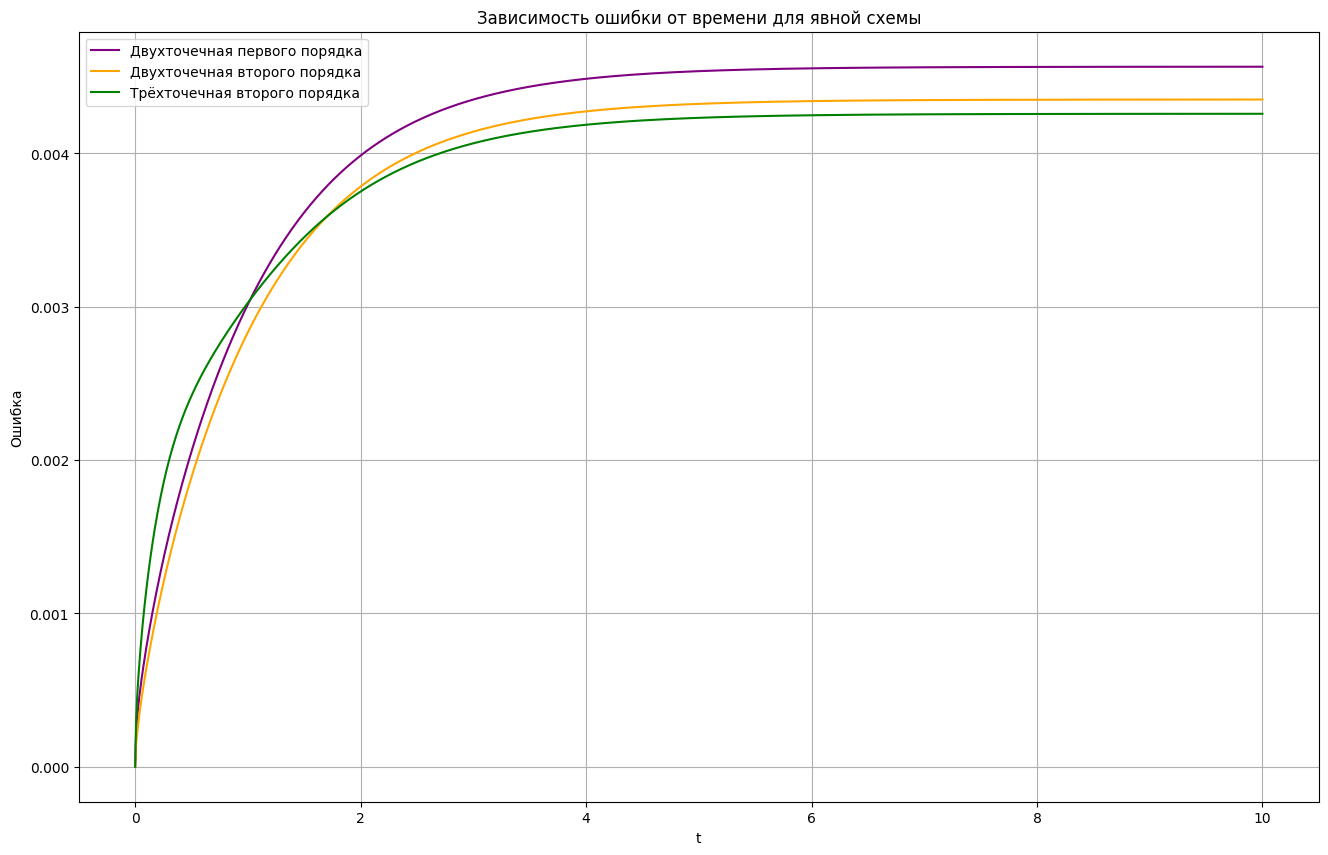

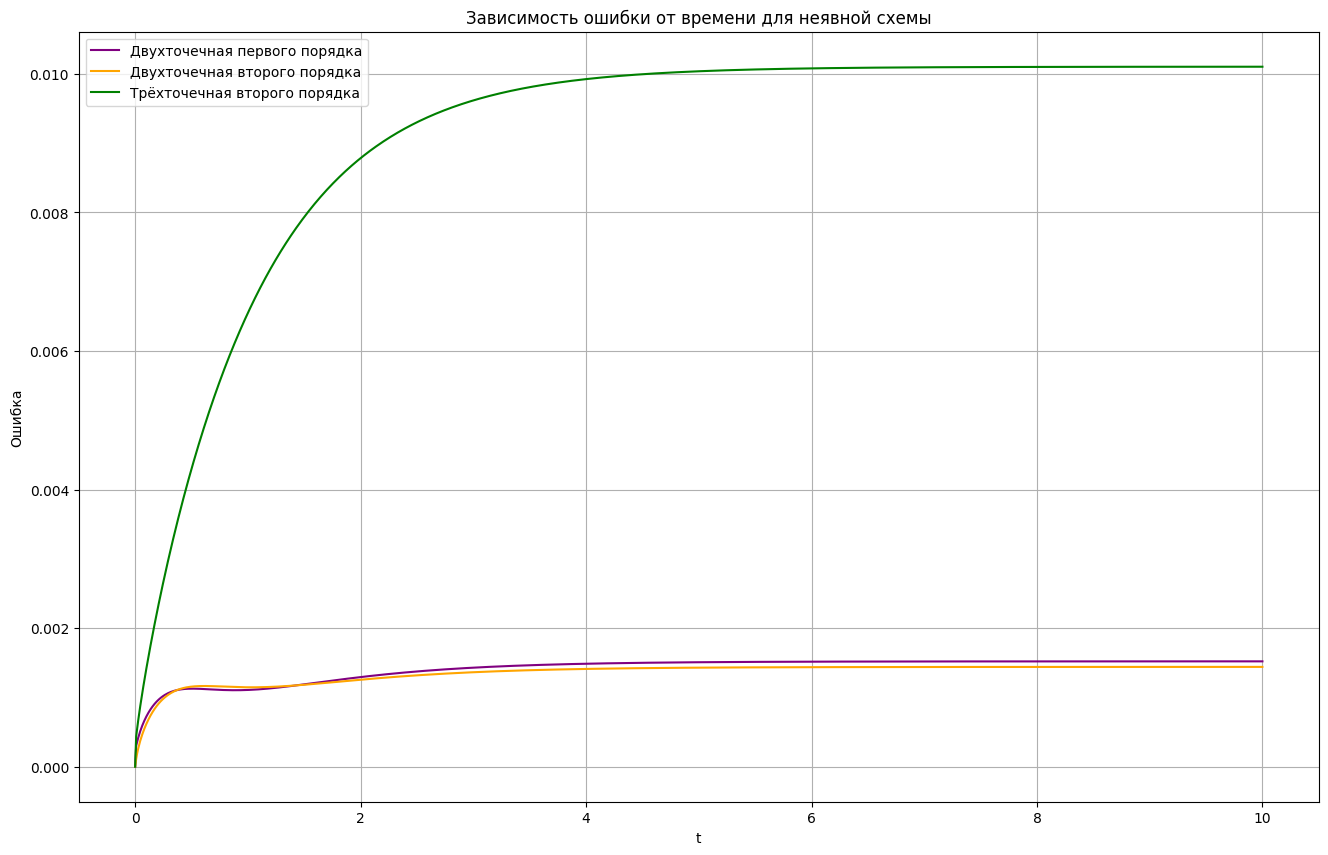

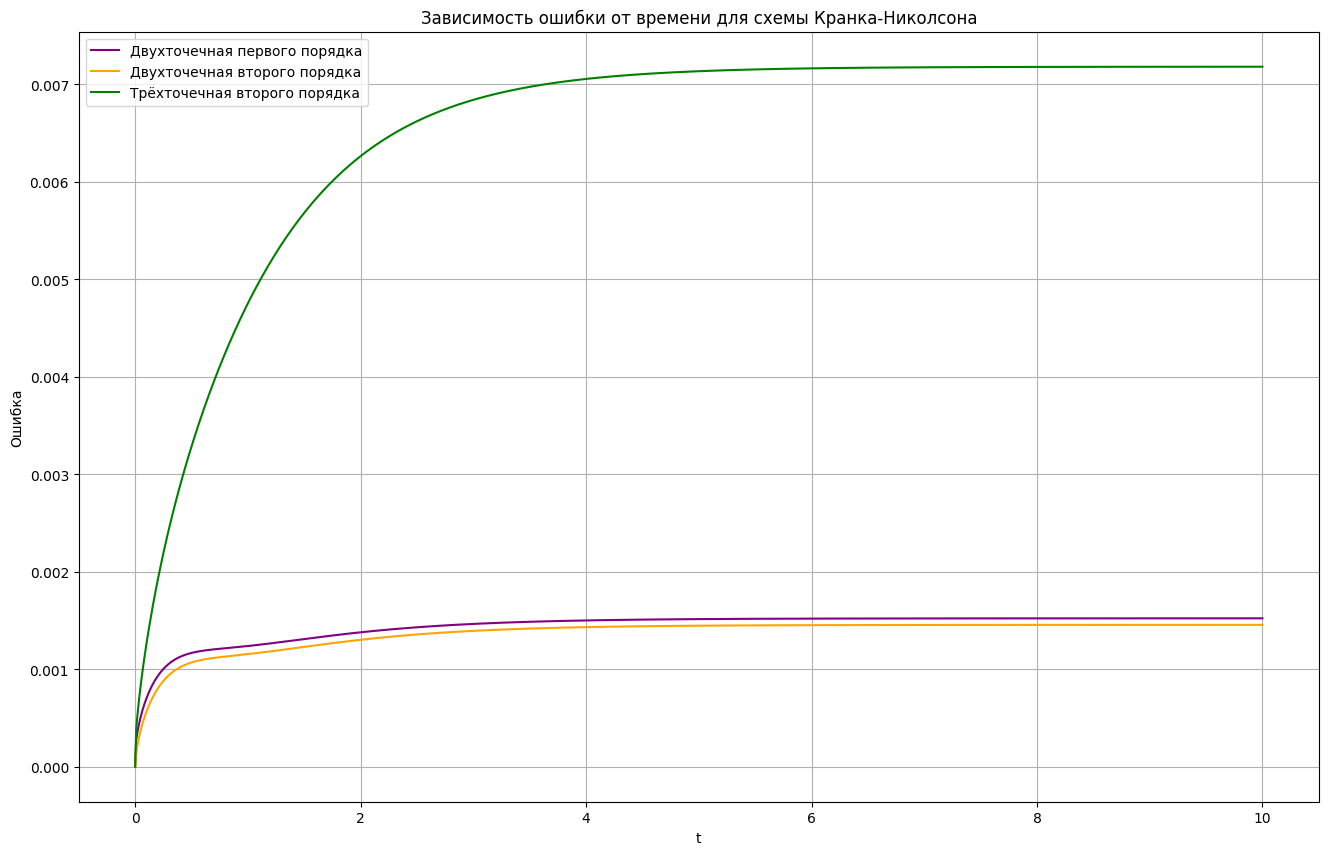

In [9]:
# Явная схема
plot_error_by_t(
    scheme_function=explicit_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=T_difference_by_t,
    exact_solution=exact_by_t,
    K=K,
    title="Зависимость ошибки от времени для явной схемы",
    t=t,
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

# Невная схема
plot_error_by_t(
    scheme_function=lambda T, approx_scheme: krank_nikolson(T=T, approx_scheme=approx_scheme, teta=1),
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=T_difference_by_t,
    exact_solution=exact_by_t,
    K=K,
    title="Зависимость ошибки от времени для неявной схемы",
    t=t,
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

# Схема Кранка-Николсона
plot_error_by_t(
    scheme_function=krank_nikolson,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=T_difference_by_t,
    exact_solution=exact_by_t,
    K=K,
    title="Зависимость ошибки от времени для схемы Кранка-Николсона",
    t=t,
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

## Построение графиков зависимости погрешности от h

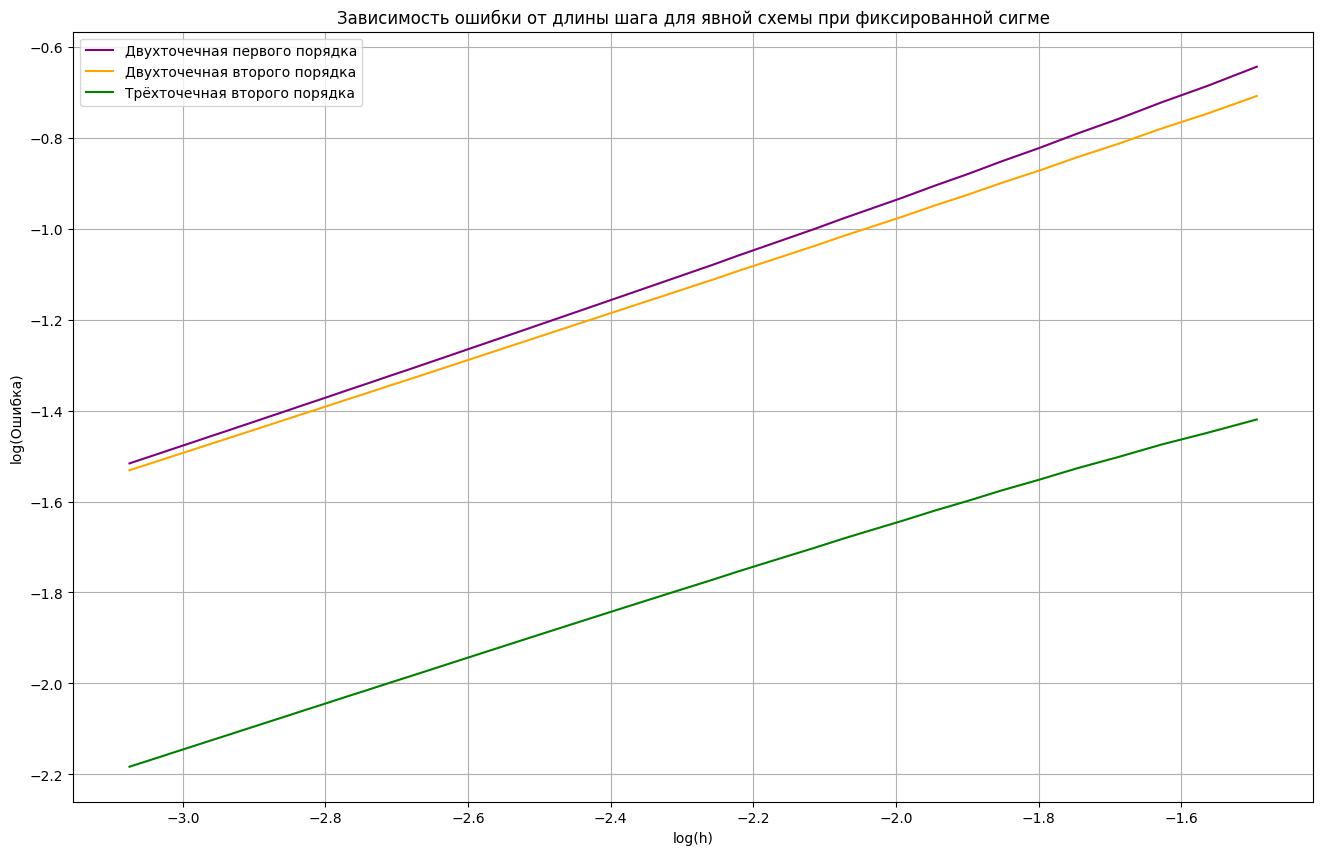

Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:
Двухточечная первого порядка: 1.8111
Двухточечная второго порядка: 1.9198
Трёхточечная второго порядка: 2.0688


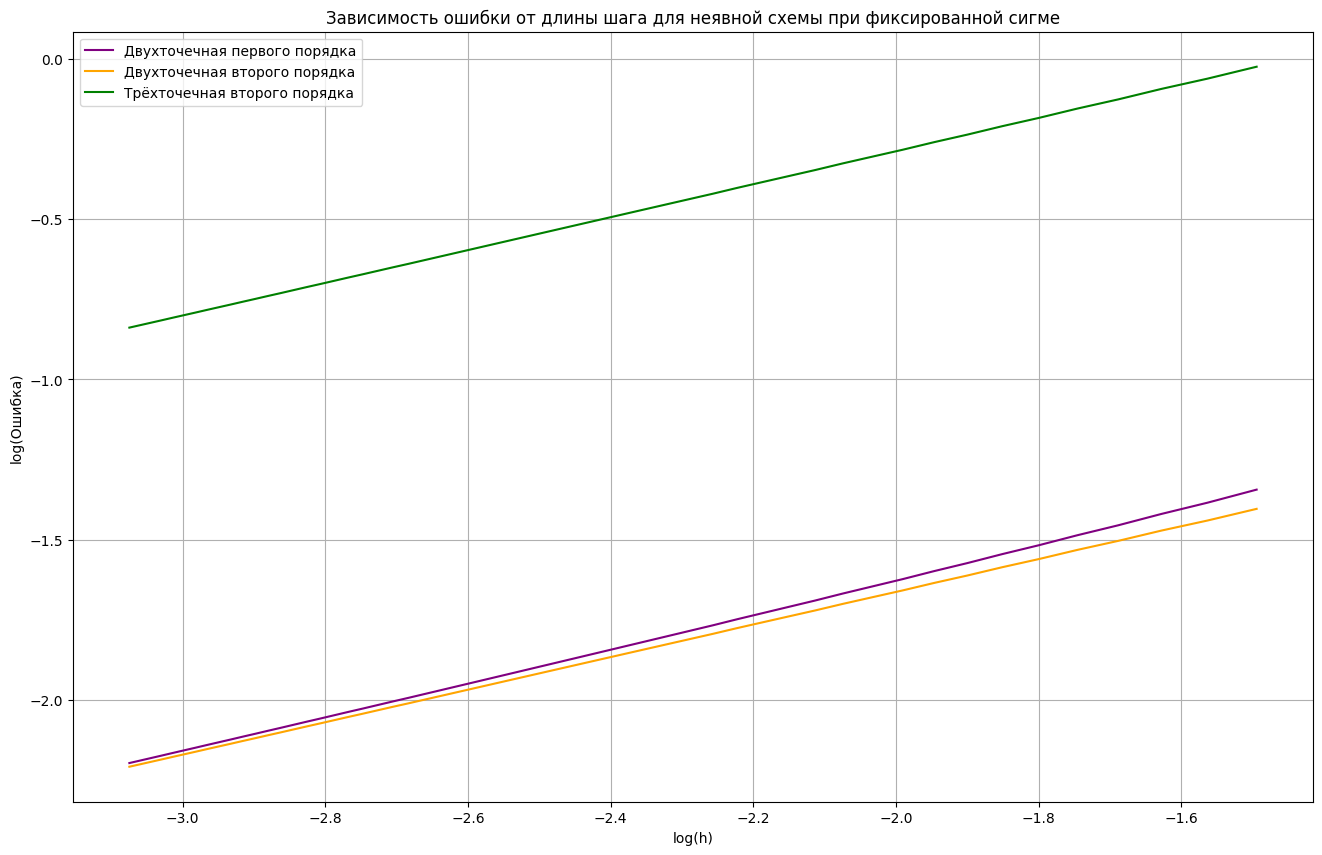

Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:
Двухточечная первого порядка: 1.8531
Двухточечная второго порядка: 1.9649
Трёхточечная второго порядка: 1.9421


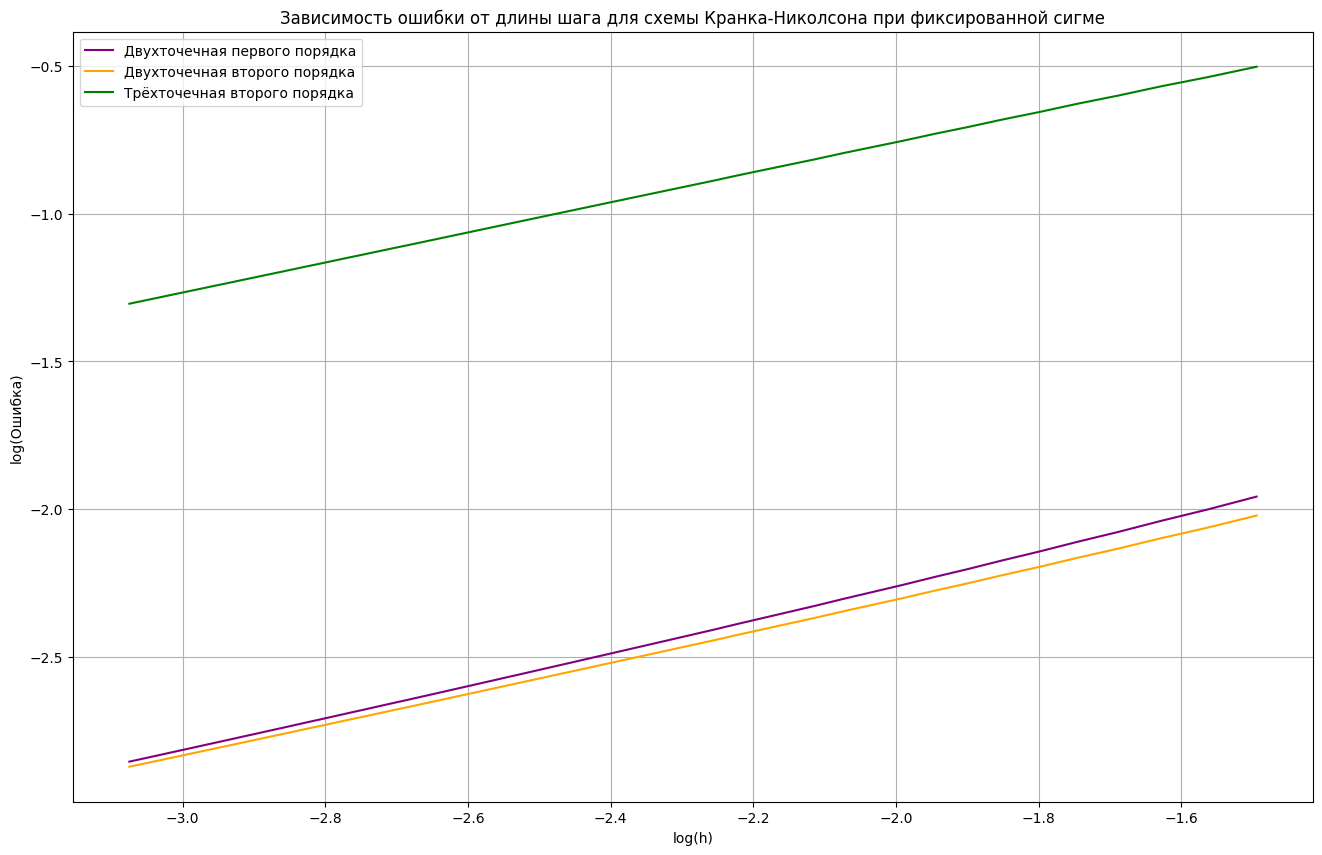

Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:
Двухточечная первого порядка: 1.7610
Двухточечная второго порядка: 1.8583
Трёхточечная второго порядка: 1.9695


In [11]:
# Явная схема
plot_error_by_h(
    scheme_function=explicit_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=5,
    exact_solution=exact_by_h,
    sigma=0.5,
    title="Зависимость ошибки от длины шага для явной схемы при фиксированной сигме",
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

# Невная схема
plot_error_by_h(
    scheme_function=lambda T, approx_scheme: krank_nikolson(T=T, approx_scheme=approx_scheme, teta=1),
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=5,
    exact_solution=exact_by_h,
    sigma=0.5,
    title="Зависимость ошибки от длины шага для неявной схемы при фиксированной сигме",
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

# Схема Кранка-Николсона
plot_error_by_h(
    scheme_function=krank_nikolson,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=5,
    exact_solution=exact_by_h,
    sigma=0.5,
    title="Зависимость ошибки от длины шага для схемы Кранка-Николсона при фиксированной сигме",
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

## Построение графиков с разными типами аппроксимации

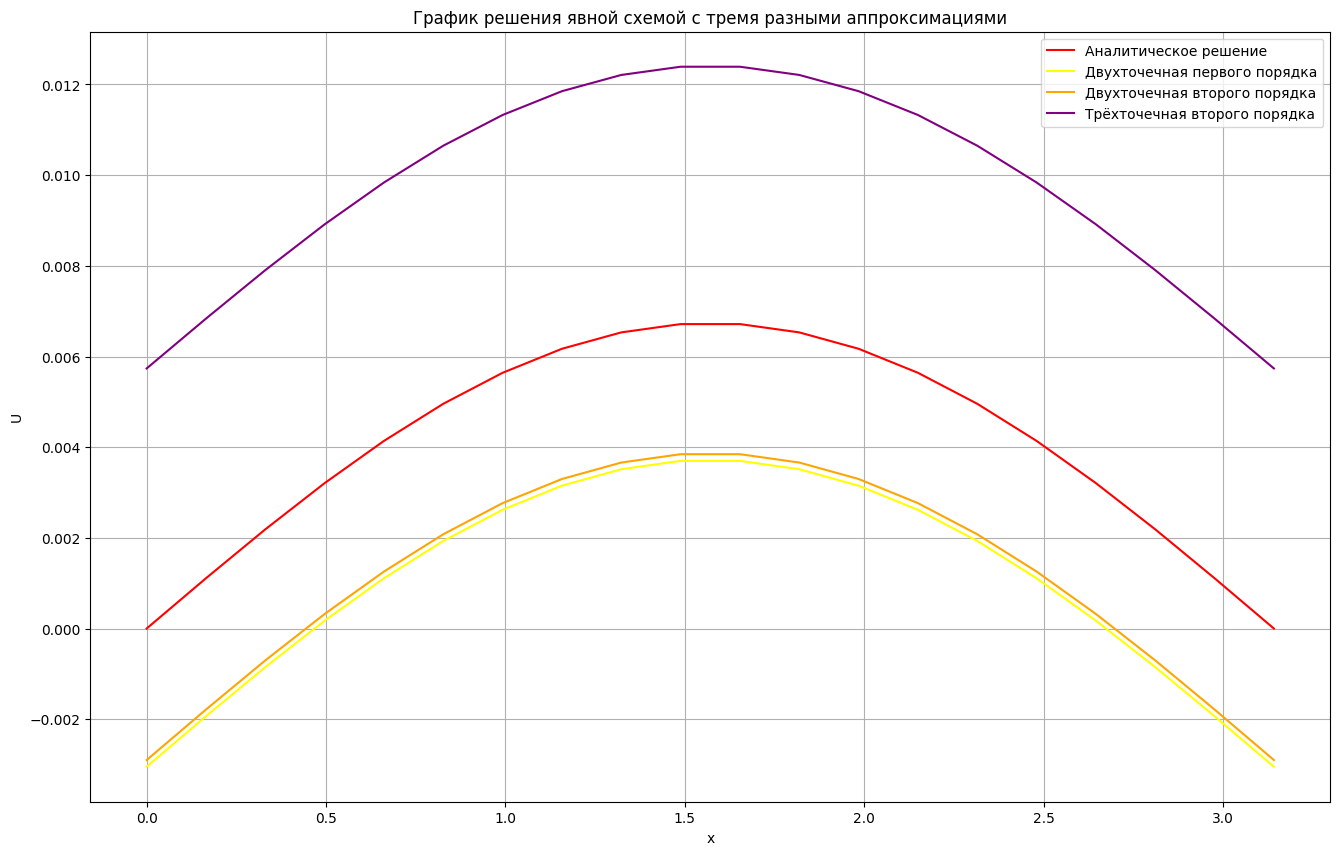

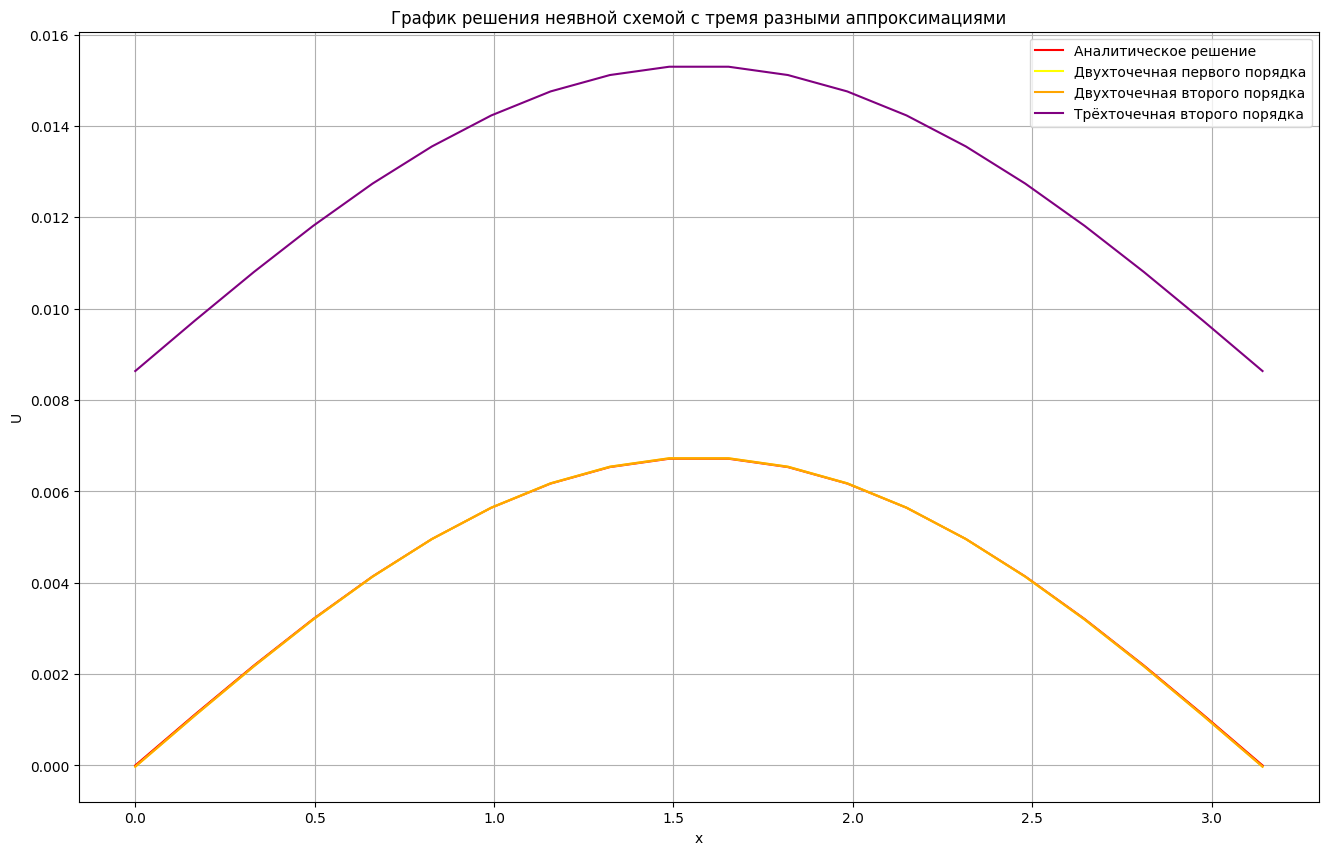

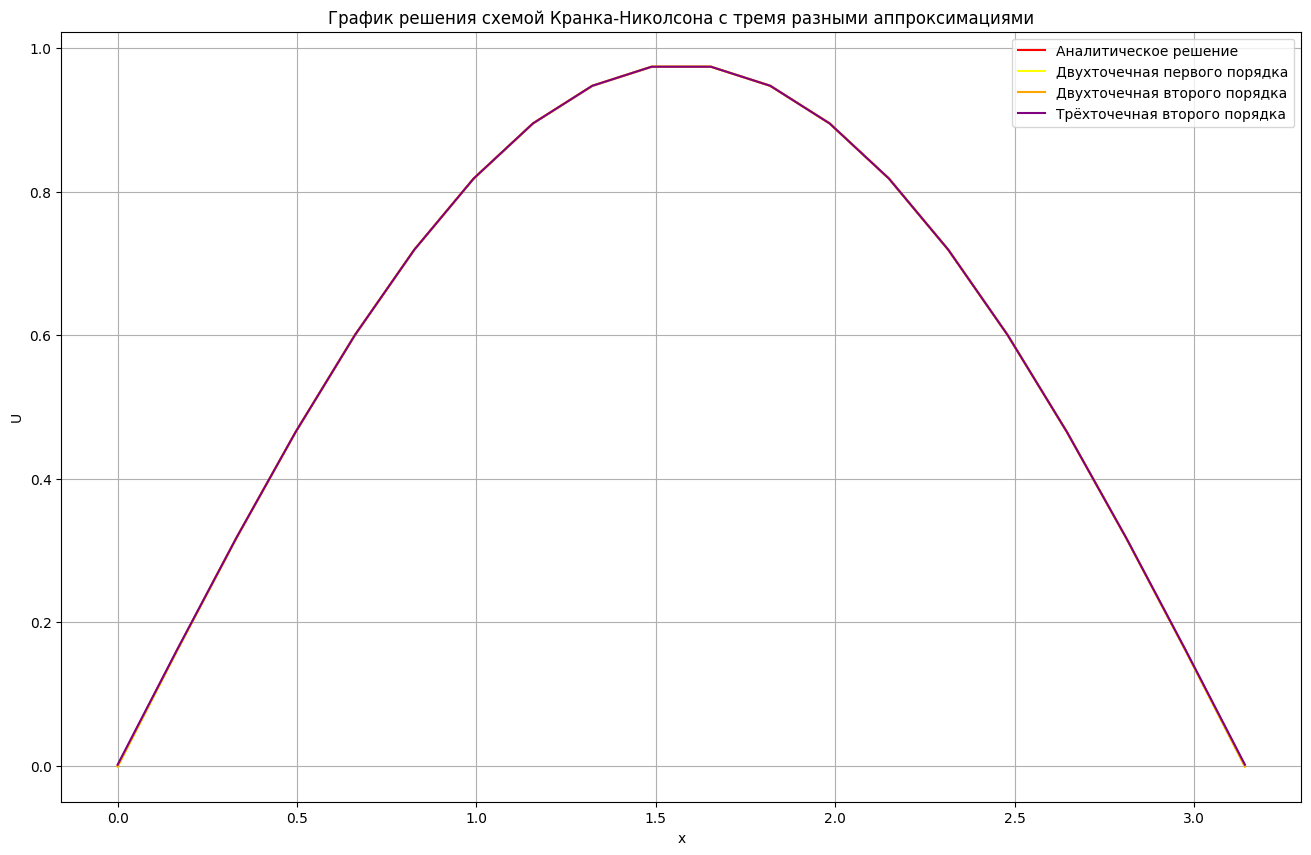

In [12]:
# Явная схема
plot_approx(
    scheme_function=explicit_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    N=N,
    x=x,
    exact_solution=exact_approx_ans,
    T=-1,  # Последний временной слой
    title="График решения явной схемой с тремя разными аппроксимациями",
    colors=["yellow", "orange", "purple"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)


# Неявная схема
plot_approx(
    scheme_function=lambda approx_scheme: krank_nikolson(approx_scheme=approx_scheme, teta=1),
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    N=N,
    x=x,
    exact_solution=exact_approx_ans,
    T=-1,  # Последний временной слой
    title="График решения неявной схемой с тремя разными аппроксимациями",
    colors=["yellow", "orange", "purple"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

# Схема Кранка-Николсона
plot_approx(
    scheme_function=krank_nikolson,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    N=N,
    x=x,
    exact_solution=exact_approx_ans,
    T=T,  # Индекс временного слоя
    title="График решения схемой Кранка-Николсона с тремя разными аппроксимациями",
    colors=["yellow", "orange", "purple"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

## Построение графиков с разными T

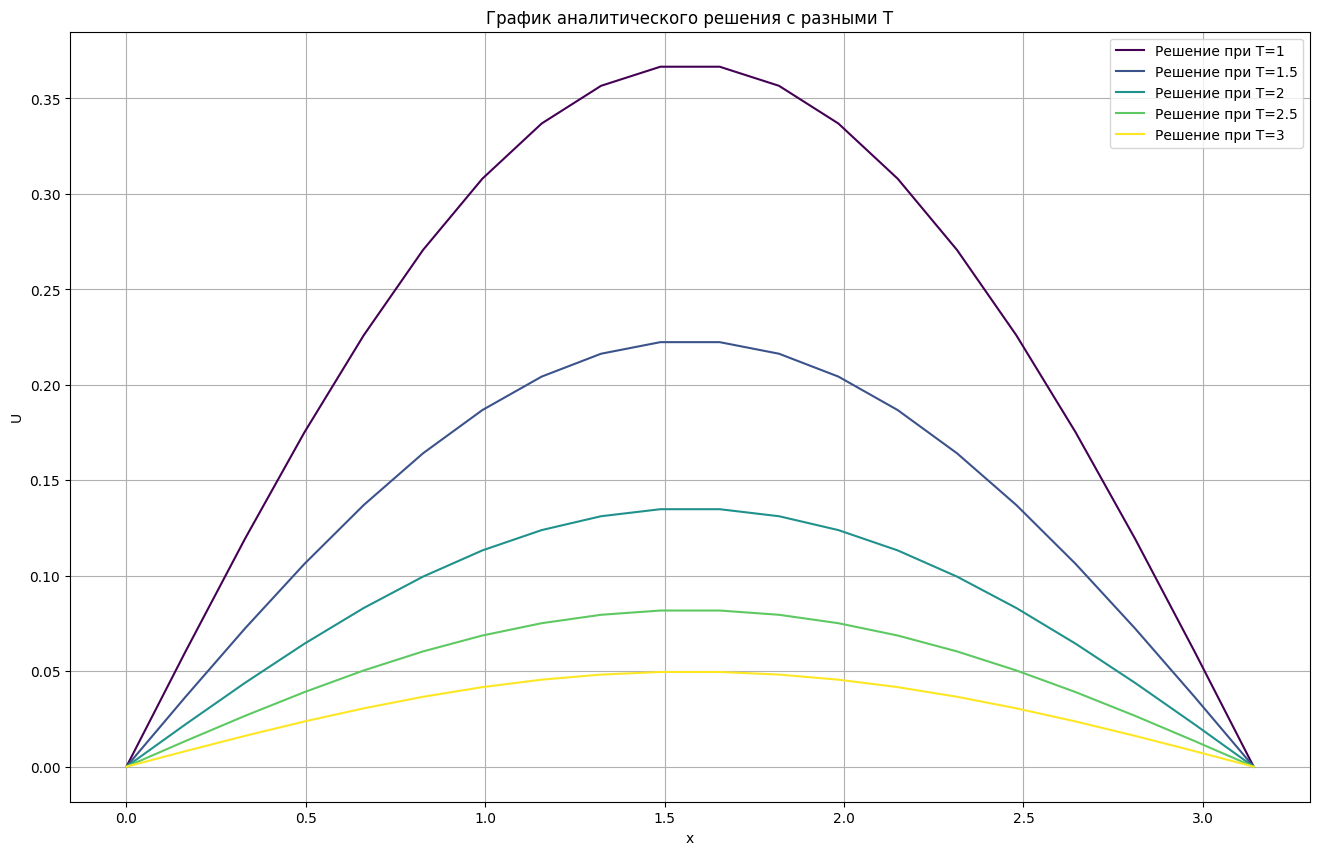

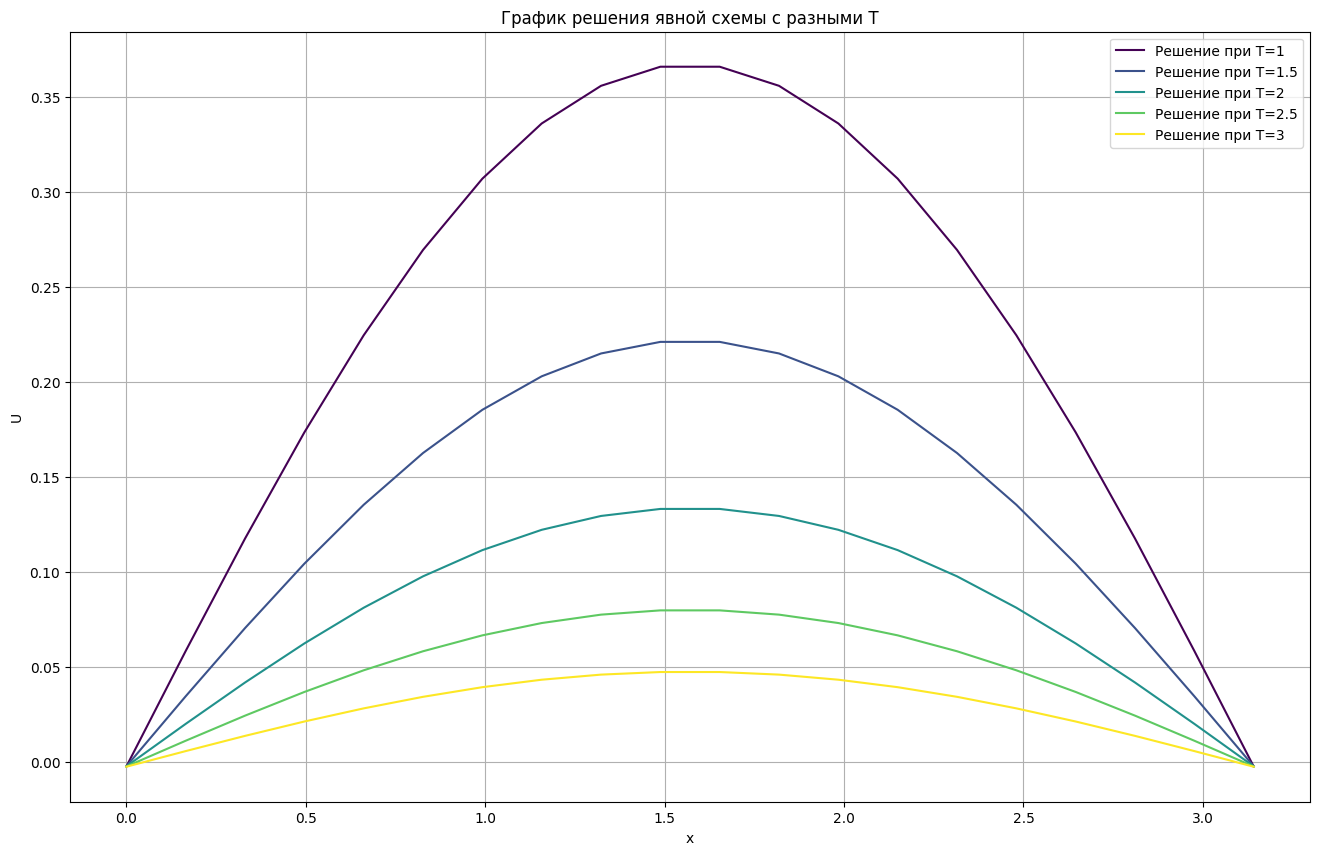

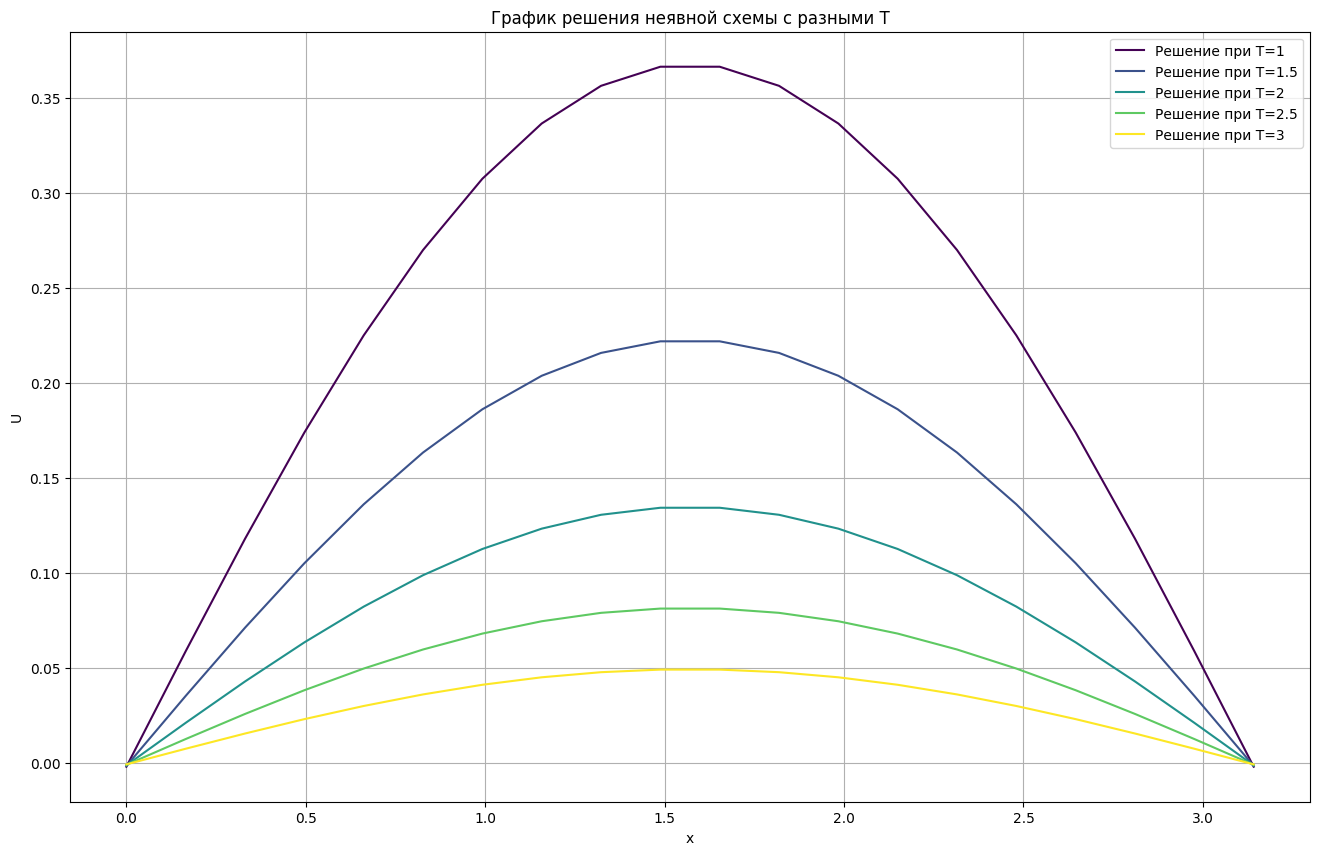

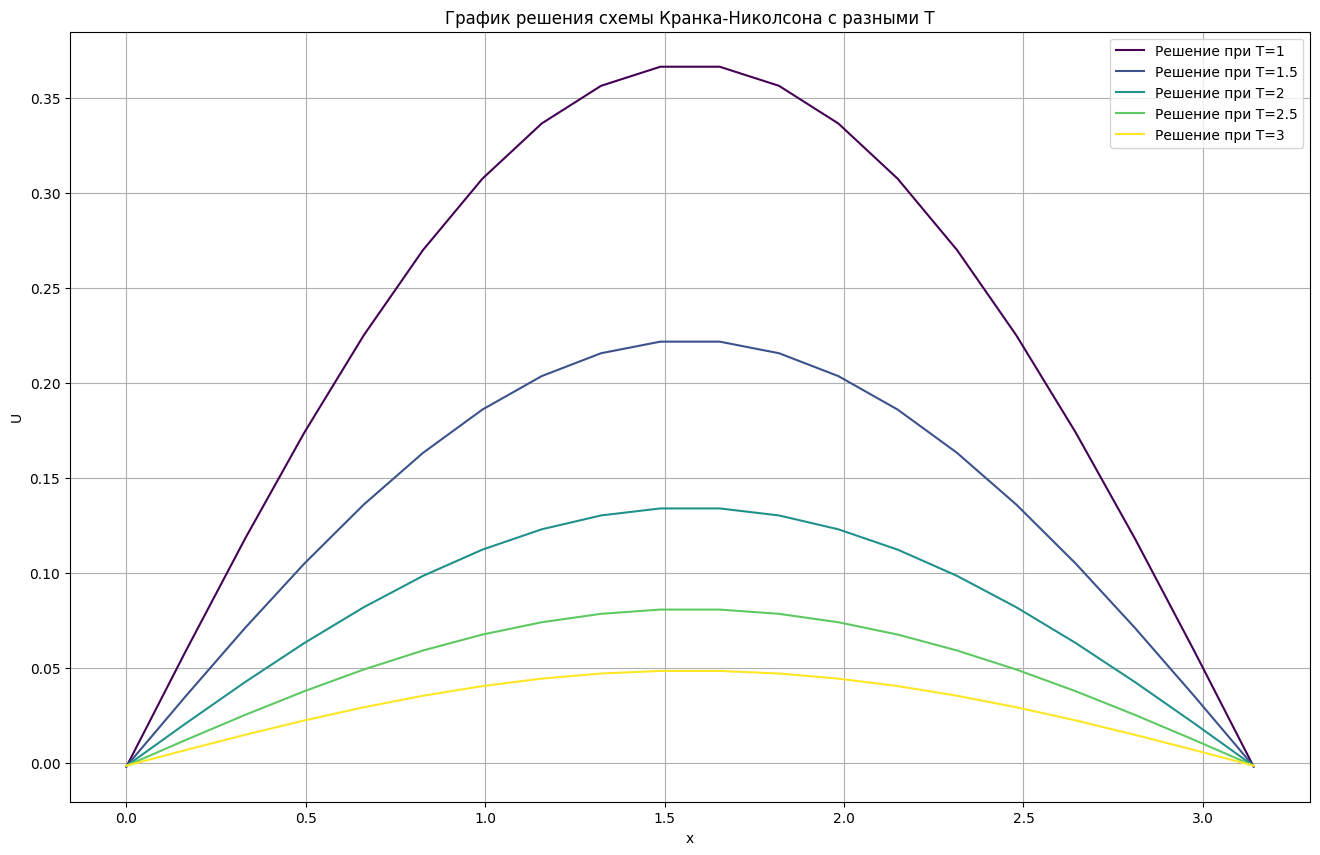

In [57]:
# Аналитическое решение
plot_solutions_with_different_T(
    scheme_function=exact_solution,
    approx_scheme=None,  # Для аналитического решения аппроксимационная схема не требуется
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График аналитического решения с разными T",
    xlabel="x",
    ylabel="U"
)

# Явная схема
plot_solutions_with_different_T(
    scheme_function=explicit_scheme,
    approx_scheme=approx_two_one,  # Указать аппроксимационную схему
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График решения явной схемы с разными T",
    xlabel="x",
    ylabel="U"
)

# Неявная схема
plot_solutions_with_different_T(
    scheme_function=lambda approx_scheme, T: krank_nikolson(approx_scheme=approx_scheme, T=T, teta=1),
    approx_scheme=approx_two_one,  # Указать аппроксимационную схему
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График решения неявной схемы с разными T",
    xlabel="x",
    ylabel="U"
)

# Схема Кранка-Николсона
plot_solutions_with_different_T(
    scheme_function=krank_nikolson,
    approx_scheme=approx_two_one,  # Указать аппроксимационную схему
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График решения схемы Кранка-Николсона с разными T",
    xlabel="x",
    ylabel="U"
)